In [ ]:
import numpy as np
import PIL
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import random

MAIN_PATH = "img_align_celeba"

In [ ]:
image_paths = glob(MAIN_PATH+"/*")

In [ ]:
len(image_paths)

9

In [ ]:
def readImage(path,image_size=(256,256)):
    img = np.asarray(PIL.Image.open(path).resize(image_size))
    # img - 127.5 / 127.5 ==> compress between [-1,1]
    img = ((img - 127.5) / 127.5).astype("float32")
    return img

(256, 256, 3)


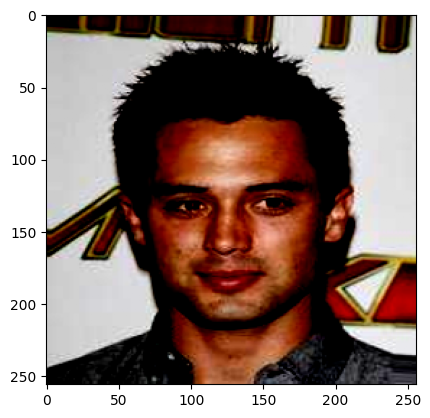

In [ ]:
test_img = readImage("img_align_celeba/000007.jpg")
print(test_img.shape)

plt.imshow(test_img)
plt.show()

In [ ]:
BATCH_SIZE = 128
#STEPS_PER_EPOCH = len(image_paths) // BATCH_SIZE
STEPS_PER_EPOCH = 2000
print("Steps per epochh are",STEPS_PER_EPOCH)
def dataGenerator(batch_size):
    while True:
        paths = random.choices(image_paths,k=batch_size)
        batch = []
        for p in paths:
            batch.append(readImage(p))

        yield np.asarray(batch)

dataGen = dataGenerator(BATCH_SIZE)
print(next(dataGen).shape)

Steps per epochh are 500
(128, 256, 256, 3)


In [ ]:
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0,stddev=0.2)
def make_generator():
    model = tf.keras.Sequential()

    # Random noise to 16x16x256 image
    model.add(layers.Dense(16*16*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((16,16,256)))

    assert model.output_shape == (None,16,16,256)

    model.add(layers.Conv2DTranspose(128,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    assert model.output_shape == (None,32,32,128)

    model.add(layers.Conv2DTranspose(128,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    assert model.output_shape == (None,64,64,128)

    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    assert model.output_shape == (None,128,128,64)

    model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),use_bias=False,padding="same",kernel_initializer=WEIGHT_INIT,
                                     activation="tanh"
                                    ))
              # Tanh activation function compress values between -1 and 1.
              # This is why we compressed our images between -1 and 1 in readImage function.
    assert model.output_shape == (None,256,256,3)
    return model

In [ ]:
generator = make_generator()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 65536)             6553600   
                                                                 
 batch_normalization_4 (Bat  (None, 65536)             262144    
 chNormalization)                                                
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 65536)             0         
                                                                 
 reshape_1 (Reshape)         (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 32, 32, 128)       819200    
 Transpose)                                                      
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 128)      

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    # First argument of loss is real labels
    # We've labeled our images as 1 (real) because
    # we're trying to fool discriminator
    return cross_entropy(tf.ones_like(fake_output),fake_output)

gen_optimizer = tf.keras.optimizers.Adam(lr=1e-4)

In [ ]:
def make_discriminator():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding="same",input_shape=(256,256,3)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(265,(5,5),strides=(2,2),padding="same"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator()

In [ ]:
def discriminator_loss(real_images,fake_images):
    real_loss = cross_entropy(tf.ones_like(real_images),real_images)
    fake_loss = cross_entropy(tf.zeros_like(fake_images),fake_images)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
discriminator_optimizer = tf.keras.optimizers.Adam(lr=1e-4)

In [ ]:
EPOCHS = 5
NOISE_DIM = 100

@tf.function
def train_step(images):
    # We've created random seeds
    noise = tf.random.normal([BATCH_SIZE,NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generator generated images
        generated_images = generator(noise,training=True)

        # We've sent our real and fake images to the discriminator and taken the decisions of it.
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)

        # We've computed losses of generator and discriminator
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)

    # We've computed gradients of networks and updated variables using those gradients.
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

In [ ]:
import time
import sys
def train(epochs):
    for epoch in range(epochs):
        start = time.time()
        for step in range(STEPS_PER_EPOCH):
            train_step(next(dataGen))

            sys.stdout.write(f"\rSTEP: {step}/{STEPS_PER_EPOCH}")
            sys.stdout.flush()

        finish_time = round(time.time() - start,2)
        print(f"Epoch {epoch}/{epochs} Process Time : {finish_time}")
        print("-"*15)


In [ ]:
train(EPOCHS)

STEP: 499/500Epoch 0/5 Process Time : 891.91
---------------
STEP: 499/500Epoch 1/5 Process Time : 865.8
---------------
STEP: 499/500Epoch 2/5 Process Time : 865.26
---------------
STEP: 499/500Epoch 3/5 Process Time : 867.43
---------------
STEP: 50/500

In [ ]:
noise = tf.random.normal([16,100])
generated_images = np.asarray(generator(noise,training=False))

fig = plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow((generated_images[i,:,:,:]*127.5+127.5).astype("int"))
    plt.axis("off")

plt.show()

In [ ]:
generator.save('images/celeba')